In [1]:
using AddressingRequirements
using LinearAlgebra, Plots, StatsPlots, LaTeXStrings, Measures
kwargs = (size=(1000,400), margin=5mm);

## Usage

Specifying the total number of atoms N and the system type creates a cavity setup as detailed in the paper. Atoms targeted for performing a quantum gate are denoted by "x" and non-targeted atoms by "o" in the visualization. Photon frequency ωp is set on resonance with the bare cavity frequency ωc by default, which for simplicity is ωp = ωc = 0. All frequencies given in units of $2\pi$ x MHz.

In [2]:
sys = System(N = 6, mode = :remote)

Remote Gate | N = 6 | [xoo]--[xoo] | ωp = 0.0


In [3]:
sys = System(N = 4, mode = :local)

Local Gate | N = 4 | [xxoo]-- | ωp = 0.0


By default we assume Cesium atoms with qubit splitting ωq, spontaneous emission rate 2γ and a transition coupling them to the cavity on resonance ωa = 0.

In [4]:
atom = Atom()

Atom | Target: false | ωq = 9192.6 | γ = 2.6 | g = 0.0 | ωa = 0.0


Create an empty cavity with default decay rate κr and mirror loss and transmission loss rates κm and κt respectively.

In [5]:
cav = Cavity()

Cavity [] | κr/κ = 0.9259 | (κr,κm,κt) = (2.50,0.10,0.10) | ωc = 0.0


Local and remote gate fidelities are calculated numerically either via the approximative superposition input...

In [6]:
sys = System(N = 2, mode = :local)
coupling = 7.8
set_coupling(sys,coupling)
input = normalize(ones(2^sys.N))
target = CZ_unitary(input,sys)
fidelity(local_gate(density_matrix(input),sys),target)

0.9980076348344614

... or via the Choi operator

In [7]:
sys = System(N = 2, mode = :remote)
coupling = 7.8
set_coupling(sys,coupling)
input_choi = choi_state(sys.N)
target_choi = choi(CZ_unitary(nothing,sys))*input_choi
fidelity(remote_gate(nothing,sys,choi=true),target_choi,choi=true)

0.9839812023553535

Similarly for gate success probabilities

In [8]:
success_probability(sys)

0.717059299786913

## Fig. 5 - Choi / Approx. Comparison

In [9]:
g_range = LinRange(0,30,301)
sys = System(N = 2, mode = :local, κr = 2.0)
input = normalize(ones(2^sys.N))
target = CZ_unitary(input,sys)
input_choi = choi_state(sys.N)
target_choi = choi(CZ_unitary(nothing,sys))*input_choi

infidelity_approx = []
infidelity_choi = []

for coupling in g_range
    set_coupling(sys,coupling)
    result = 1 - fidelity(local_gate(density_matrix(input),sys),target)
    push!(infidelity_approx, result)
    result = 1 - fidelity(local_gate(nothing,sys,choi=true),target_choi,choi=true)
    push!(infidelity_choi, result)
end

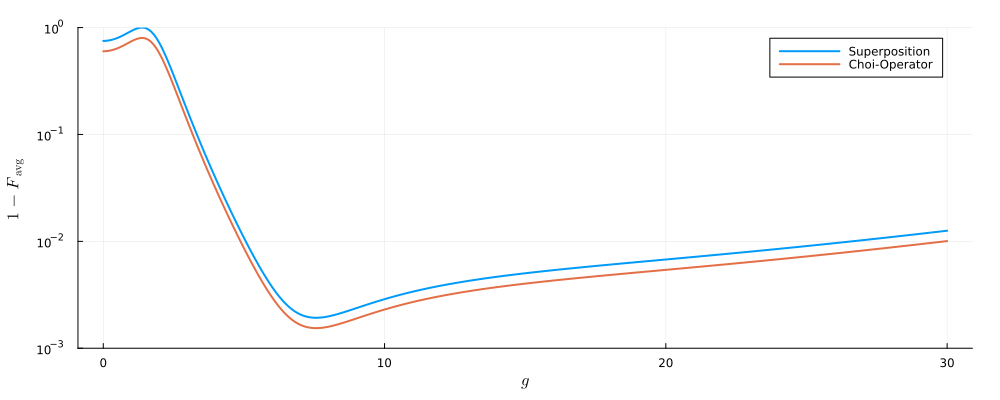

In [10]:
p = plot(g_range,infidelity_approx,label="Superposition",lw=2)
p = plot!(g_range,infidelity_choi,label="Choi-Operator",lw=2)
plot(p,yscale=:log10,ylims=(1e-3,1),xlabel=L"$g$",ylabel=L"$1-F_\mathrm{avg}$"; kwargs...)

In [11]:
fname = "data/local_gate_N2_infidelity_choi_superpos.dat"
labels = ["g" "FS" "FC"]
data = [g_range infidelity_approx infidelity_choi]
save_data(fname,labels,data)

## Fig. 8 - Nanofiber Coupling Strength

In [12]:
fiber = fiber_parameters(l = 1, n1 = 1.4537, n2 = 1., a = 200e-9, λ = 852.3e-9)
gridsize, posmax = 500, 10
x = LinRange(-posmax,posmax,gridsize)
dx = abs(x[2]-x[1])

Ex_linear = [fiber_mode_linear([x,y,0.],fiber; pol_angle = 0.)[1] for y in x, x in x]
Ex_circular = [fiber_mode([x,y,0.],fiber)[1] for y in x, x in x]
intensity_linear = [sum(abs2.(fiber_mode_linear([x,y,0.],fiber; pol_angle = 0.))) for y in x, x in x]
intensity_circular = [sum(abs2.(fiber_mode([x,y,0.],fiber))) for y in x, x in x]
linmax = maximum(intensity_linear);  

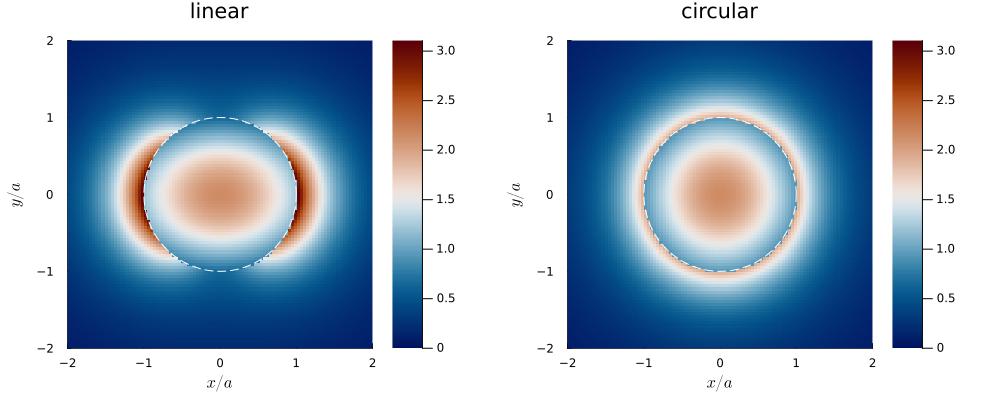

In [13]:
ϕ = LinRange(0,2*π,100)
p1 = heatmap(x,x,intensity_linear,cmap=:vik,title="linear")
p1 = plot!(cos.(ϕ),sin.(ϕ),ls=:dash,lw=1,color="white",legend=false)
p2 = heatmap(x,x,intensity_circular,cmap=:vik,title="circular")
p2 = plot!(cos.(ϕ),sin.(ϕ),ls=:dash,lw=1,color="white",legend=false)
plot(p1,p2,layout=(1,2),xlims=(-2,2),ylims=(-2,2),clims=(0,linmax),xlabel=L"x/a",ylabel=L"y/a"; kwargs...) 

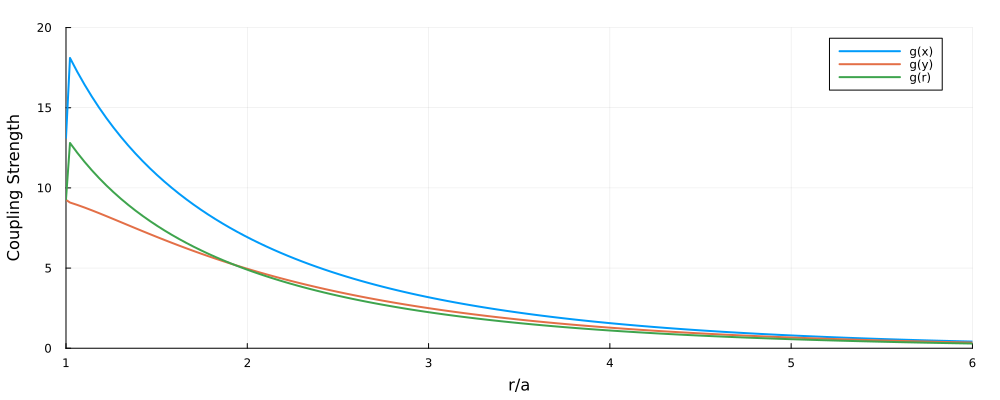

In [14]:
g_lin = fiber_coupling(fiber,intensity_linear,dx, Lcav = 0.15, dipole_factor = sqrt(5/18))
g_circ = fiber_coupling(fiber,intensity_circular,dx, Lcav = 0.15, dipole_factor = sqrt(5/18))

# quantization axis along x
couplings_x_circular = g_circ*abs.(Ex_circular[Int(gridsize/2),:])
couplings_y_circular = g_circ*abs.(Ex_circular[:,Int(gridsize/2)])
couplings_x_linear = g_lin*abs.(Ex_linear[Int(gridsize/2),:])
couplings_y_linear = g_lin*abs.(Ex_linear[:,Int(gridsize/2)])

p = plot(x,couplings_x_linear,label="g(x)",lw=2)
p = plot!(x,couplings_y_linear,label="g(y)",lw=2)
p = plot!(x,couplings_x_circular,label="g(r)",lw=2)

plot(p,xlabel="r/a",ylabel="Coupling Strength",xlims=(1,6),ylims=(0,20); kwargs...)

In [15]:
y = copy(x)
fname = "data/fiber_HE11_mode_couplings_circular.dat"
labels = ["x" "gx" "y" "gy"]
data = [x couplings_x_circular y couplings_y_circular]
save_data(fname,labels,data)

fname = "data/fiber_HE11_mode_couplings_linear.dat"
data = [x couplings_x_linear y couplings_y_linear]
save_data(fname,labels,data)

## Fig. 9 - Analytic Fidelity 

In [16]:
g_range = LinRange(0,30,301)
detuning = 1e4
sys = System(N = 4, mode = :local, targets = [1,2], coupling = 0., κr = 2.5)
set_detuning(sys,detuning)
input_choi = choi_state(sys.N)
target_choi = choi(CZ_unitary(nothing,sys))*input_choi

F_num = []
F_simp = []
F_full = []

for coupling in g_range
    set_coupling(sys,coupling)
    push!(F_num,fidelity(local_gate(nothing,sys,choi=true),target_choi,choi=true))
    push!(F_simp,fidelity_local_ana(coupling,sys.cavities[1]))              
    push!(F_full,fidelity_local_ana_full(sys.cavities[1],sys)) 
end

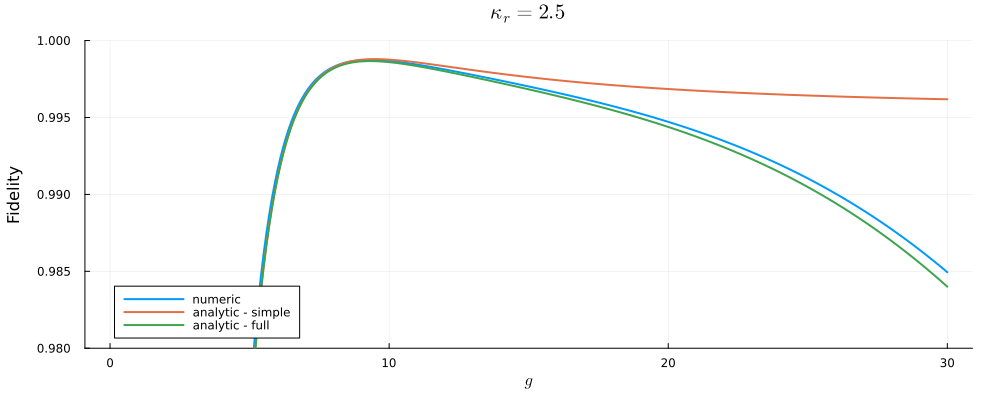

In [17]:
p = plot(g_range,F_num,label="numeric",lw=2)
p = plot!(g_range,F_simp,label="analytic - simple",lw=2)
p = plot!(g_range,F_full,label="analytic - full",lw=2)
plot(p,ylims=(0.98,1),xlabel=L"$g$",ylabel="Fidelity",title=L"$\kappa_r=2.5$"; kwargs...)

In [18]:
fname = "data/local_gate_analytic_fidelity.dat"
labels = ["g" "F_num" "F_simp" "F_full"]
data = [g_range F_num F_simp F_full]
save_data(fname,labels,data)

## Fig. 10 - Baseline Case

In [19]:
g_range = LinRange(0,50,501)

function Fig10_g(mode::Symbol)
    sys = System(N = 2, κr = 4.0, κt = 0.1, κm = 0.1; mode)
    target = choi(CZ_unitary(nothing,sys))*choi_state(sys.N)
    func = Symbol(String(mode) * "_gate")
    channel = @eval $func
    
    fid = Float64[]
    ps = Float64[]

    for coupling in g_range
        set_coupling(sys,coupling)
        push!(fid,fidelity(channel(nothing,sys,choi=true),target,choi=true))
        push!(ps,success_probability(sys))
    end
    
    return fid,ps
end

fidelity_local, ps_local = Fig10_g(:local)
fidelity_remote, ps_remote = Fig10_g(:remote)
        
infidelity_local = 1 .- fidelity_local
infidelity_remote = 1 .- fidelity_remote;

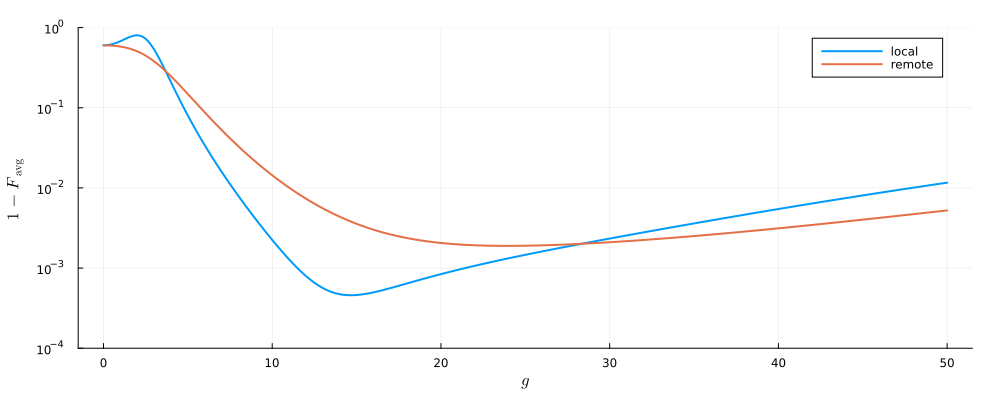

In [20]:
p = plot(g_range,infidelity_local,label="local",lw=2)
p = plot!(g_range,infidelity_remote,label="remote",lw=2)
plot(p,yscale=:log10,ylims=(1e-4,1),xlabel=L"$g$",ylabel=L"$1-F_\mathrm{avg}$"; kwargs...)

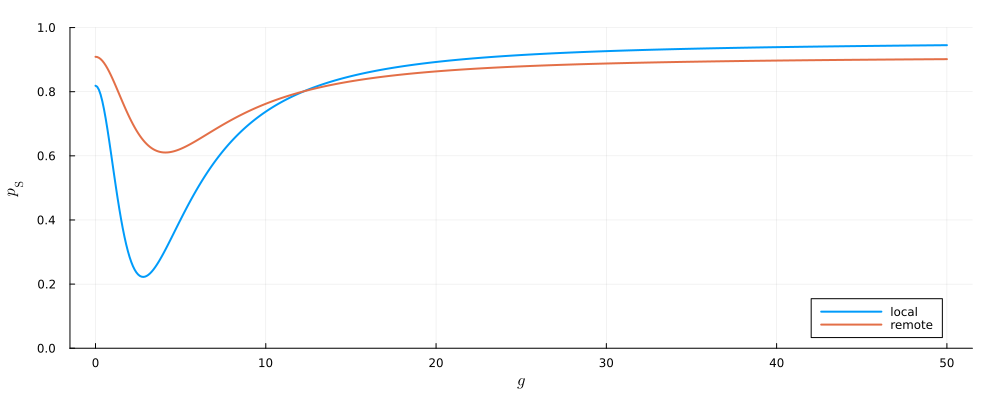

In [21]:
p = plot(g_range,ps_local,label="local",lw=2)
p = plot!(g_range,ps_remote,label="remote",lw=2)
plot(p,ylims=(0,1),xlabel=L"$g$",ylabel=L"$p_\mathrm{S}$"; kwargs...)

In [22]:
fname = "data/infidelity_ps_local_remote_gate_N2_coupling.dat"
labels = ["g" "infid_local" "infid_remote" "ps_local" "ps_remote"]
data = [g_range infidelity_local infidelity_remote ps_local ps_remote]
save_data(fname,labels,data)

In [23]:
κ_range = LinRange(0,20,401)

function Fig10_kappa(mode::Symbol)
    sys = System(N = 2, coupling = 7.8; mode)
    target = choi(CZ_unitary(nothing,sys))*choi_state(sys.N)
    func = Symbol(String(mode) * "_gate")
    channel = @eval $func
    
    fid = Float64[]
    ps = Float64[]

    for κr in κ_range
        set_cavity_decay(sys,κr)
        push!(fid,fidelity(channel(nothing,sys,choi=true),target,choi=true))
        push!(ps,success_probability(sys))
    end
    
    return fid,ps
end

fidelity_local, ps_local = Fig10_kappa(:local)
fidelity_remote, ps_remote = Fig10_kappa(:remote)
    
infidelity_local = 1 .- fidelity_local
infidelity_remote = 1 .- fidelity_remote;

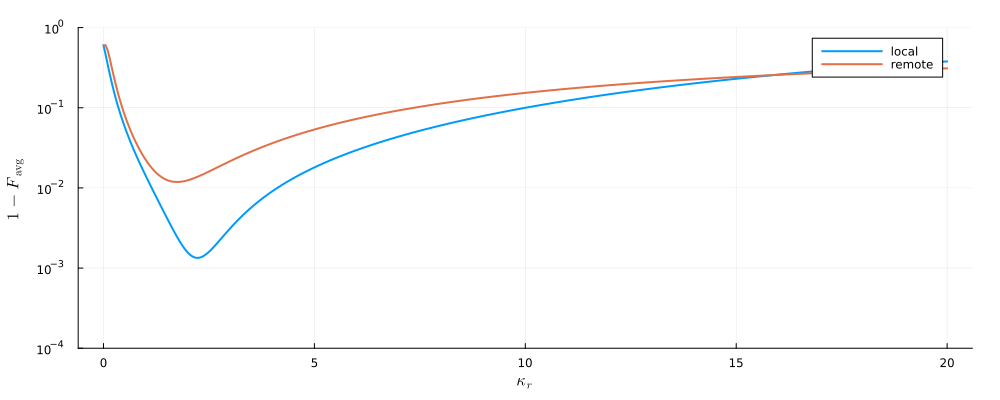

In [24]:
p = plot(κ_range,infidelity_local,label="local",lw=2)
p = plot!(κ_range,infidelity_remote,label="remote",lw=2)
plot(p,yscale=:log10,ylims=(1e-4,1),xlabel=L"$\kappa_r$",ylabel=L"$1-F_\mathrm{avg}$"; kwargs...)

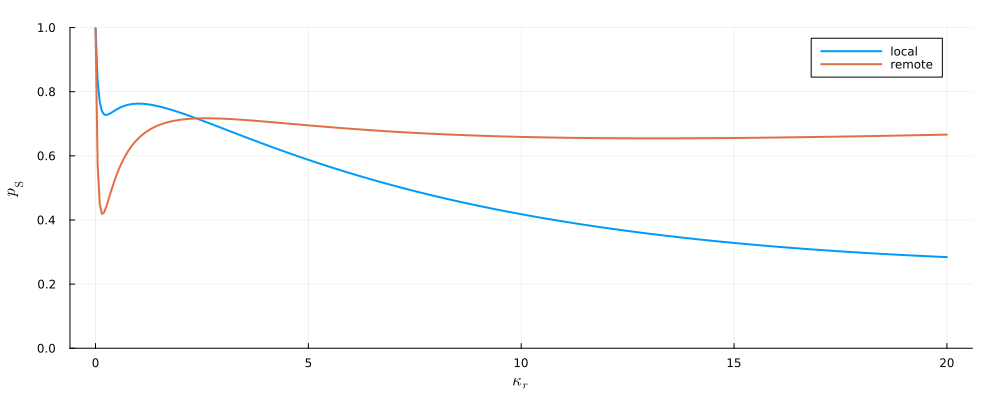

In [25]:
p = plot(κ_range,ps_local,label="local",lw=2)
p = plot!(κ_range,ps_remote,label="remote",lw=2)
plot(p,ylims=(0,1),xlabel=L"$\kappa_r$",ylabel=L"$p_\mathrm{S}$"; kwargs...)

In [26]:
fname = "data/infidelity_ps_local_remote_gate_N2_kappa.dat"
labels = ["kappa" "infid_local" "infid_remote" "ps_local" "ps_remote"]
data = [κ_range infidelity_local infidelity_remote ps_local ps_remote]
save_data(fname,labels,data)

## Fig. 11 - Fmax and qubit limit

In [27]:
cooperativity(x) = x/(1 - x) - 1
loss_ratio(F) = 1 - (20*sqrt(F*(1-F)) + sqrt(48)*(1-F))/(sqrt(75) + 28*sqrt(F*(1-F)))
success(x) = (1 - 2*x)^2*(7*x^2 - 4*x + 1)/(3*x - 1)^2

exponents = LinRange(-10,-1,200)
fidelity_range = @. 1 - 10^exponents
infidelity = 1 .- fidelity_range

plt_loss_ratio = @. 1 - loss_ratio(fidelity_range)
plt_cooperativity = @. cooperativity(loss_ratio(fidelity_range))
plt_success = @. 1 - success(loss_ratio(fidelity_range));

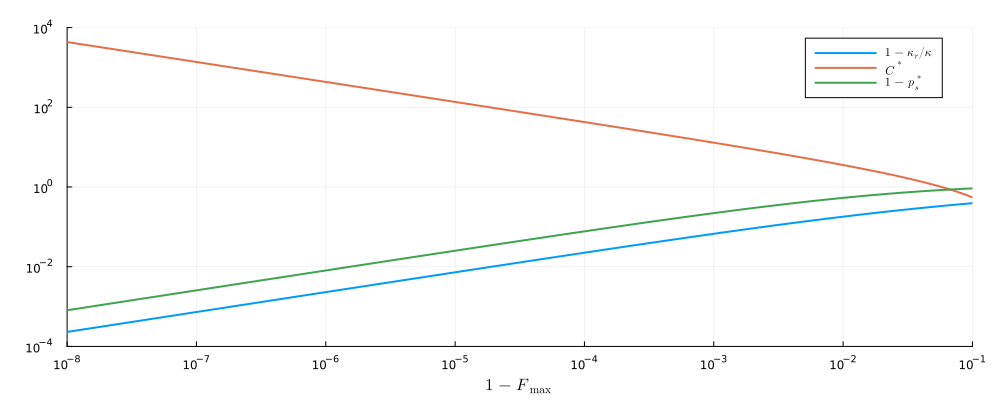

In [28]:
p = plot(infidelity,plt_loss_ratio,label=L"1 - \kappa_r/\kappa",lw=2)
p = plot!(infidelity,plt_cooperativity,label=L"C^*",lw=2)
p = plot!(infidelity,plt_success,label=L"1 - p_s^*",lw=2)
plot(p,xscale=:log10,yscale=:log10,xlims=(1e-8,0.1),ylims=(1e-4,1e4),xlabel=L"$1-F_\mathrm{max}$"; kwargs...)

In [29]:
fname = "data/local_gate_max_fidelity_requirements.dat"
labels = ["infid" "kappa_ratio" "coop" "error"]
data = [infidelity plt_loss_ratio plt_cooperativity plt_success]
save_data(fname,labels,data)

### Maximum fidelity for physical setup with adjusted ωq and coupling for |0> state

In [30]:
κr = 4.
γ = 2.6
ωq = 9.1926e3 - 251.0916
adjust_coupling = true
x = LinRange(0.51,1,300)
κm_range =  @. κr*(1.0/x - 1)

sys = System(N = 2; κr, ωq, adjust_coupling)
input = normalize(ones(2^sys.N))
target = CZ_unitary(input,sys)

fid = Float64[]

for κm in κm_range
    κ = κr + κm
    gs = sqrt(γ*κ*((κr/κ)/(1 - κr/κ) - 1))
    sys = System(N = 2, κt = 0., coupling = gs; κr, κm, ωq, adjust_coupling)
    push!(fid,fidelity(local_gate(density_matrix(input),sys),target))        
end

Fmax_range = @. 3*(1 - x)^2/(4*(7*x^2 - 4*x + 1));

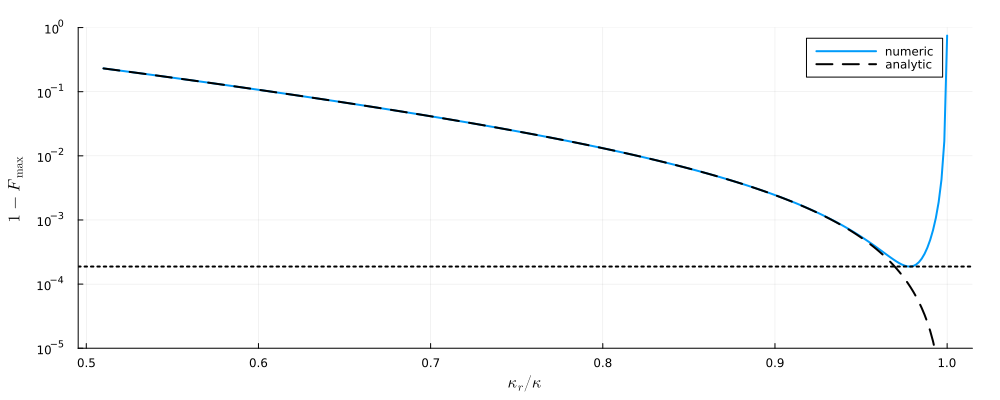

In [31]:
p = plot(x,1.0.-fid,label="numeric",lw=2)
p = plot!(x,Fmax_range,color=:black,ls=:dash,label="analytic",lw=2)
plot(p,yscale=:log10,ylims=(1e-5,1),xlabel=L"$\kappa_r/\kappa$",ylabel=L"$1-F_\mathrm{max}$"; kwargs...)
hline!([1 - maximum(fid)],color=:black,ls=:dot,label="",lw=2)

In [32]:
γ = 2.6
ωq = 9.1926e3 - 251.0916
Fmax = maximum(fid)
scaling = (1 - Fmax)/((3/7)*2*γ/ωq)
println("Maximum Gate Fidelity:")
println("1 - Fmax: $(1 - Fmax)\nLoss ratio: $(loss_ratio(Fmax))\nCooperativity: $(cooperativity(loss_ratio(Fmax)))\nProportionality constant: $(scaling)")

Maximum Gate Fidelity:
1 - Fmax: 0.00018778804806596217
Loss ratio: 0.9695544727801723
Cooperativity: 30.84554715638976
Proportionality constant: 0.7534460810519122


## Fig. 12 - Pauli Error Baseline

In [33]:
N = 2
coupling = 7.8
κr = 2.5
error_rates_local = gate_error_rates(local_gate, System(mode = :local; N, coupling, κr))
error_rates_remote = gate_error_rates(remote_gate, System(mode = :remote; N, coupling, κr));

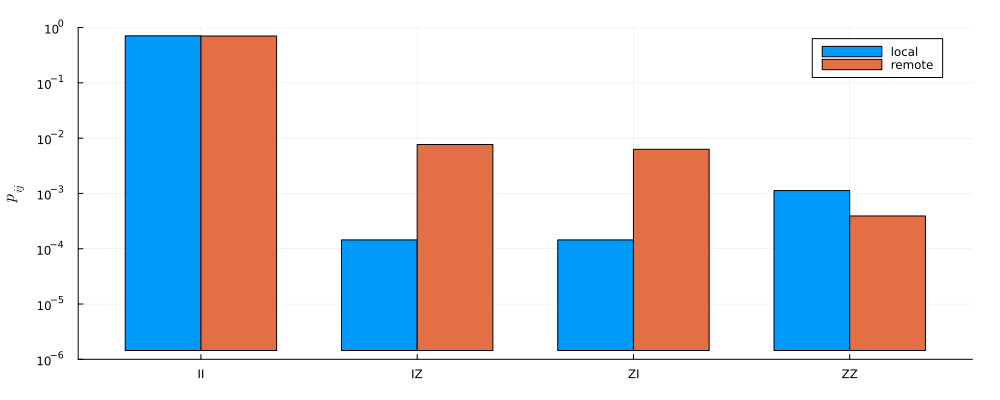

In [34]:
inds = [1,4,13,16]
labels = repeat(["II","IZ","ZI","ZZ"], outer=2)
data = [error_rates_local[inds] error_rates_remote[inds]]
legend = repeat(["local","remote"],inner=4);

p = groupedbar(labels,data,group=legend,bar_position=:dodge, bar_width=0.7, yaxis=:log)
plot(p,ylims=(1e-6,1),ylabel=L"$p_{ij}$"; kwargs...) 

In [35]:
[collect(zip(["II","IZ","ZI","ZZ"],error_rates_local[inds])), collect(zip(["II","IZ","ZI","ZZ"],error_rates_remote[inds]))]

2-element Vector{Vector{Tuple{String, Float64}}}:
 [("II", 0.7088229475844922), ("IZ", 0.00014430337226178924), ("ZI", 0.00014430337226180312), ("ZZ", 0.00112644670798423)]
 [("II", 0.7027012650087897), ("IZ", 0.007683207492748589), ("ZI", 0.00628289883512359), ("ZZ", 0.00039192845025087797)]

## Fig. 13 - Increasing N without addressing

In [36]:
N_range = 2:6

function Fig13(mode::Symbol)
    func = Symbol(String(mode) * "_gate")
    channel = @eval $func
    
    fid = Float64[]
    ps = Float64[]

    for N in N_range

        sys = System(N = N, mode = mode, coupling = 7.8, κr = 2.5)
        target = choi(CZ_unitary(nothing,sys))*choi_state(N)

        push!(fid,fidelity(channel(nothing,sys,choi=true),target,choi=true))
        push!(ps,success_probability(sys))
    end
    
    return fid,ps
end

fidelity_local, ps_local = Fig13(:local)
fidelity_remote, ps_remote = Fig13(:remote);

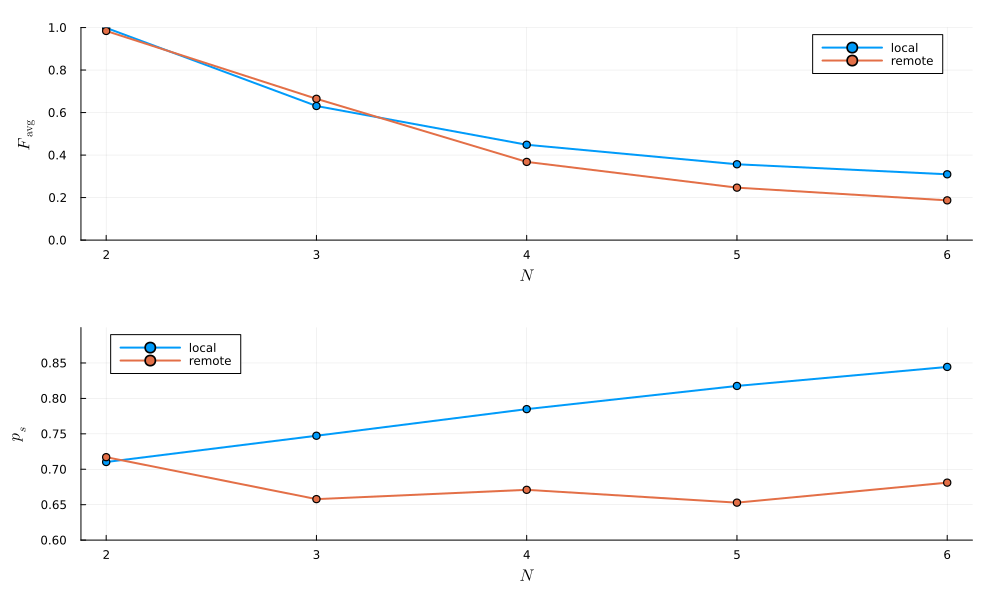

In [37]:
p1 = plot(N_range,fidelity_local,marker=:circle,label="local",ylabel=L"$F_\mathrm{avg}$",ylims=(0,1),lw=2)
plot!(N_range,fidelity_remote,marker=:circle,label="remote",lw=2)
p2 = plot(N_range,ps_local,marker=:circle,label="local",ylabel=L"$p_s$",ylims=(0.6,0.9),lw=2)
plot!(N_range,ps_remote,marker=:circle,label="remote",lw=2)
plot(p1, p2, layout=(2,1),size=(1000,600),margin=5mm,xlabel=L"$N$")

In [38]:
fname = "data/fidelity_ps_local_remote_gate_manybody_no_addressing.dat"
labels = ["N" "fid_local" "fid_remote" "ps_local" "ps_remote"]
data = [collect(N_range) fidelity_local fidelity_remote ps_local ps_remote]
save_data(fname,labels,data)

## Fig. 14 - Pauli Error N

In [39]:
N = 4
coupling = 7.8
κr = 2.5
error_rates_local = gate_error_rates(local_gate, System(mode = :local; N, coupling, κr); trace_out = true)
error_rates_remote = gate_error_rates(remote_gate, System(mode = :remote; N, coupling, κr); trace_out = true);

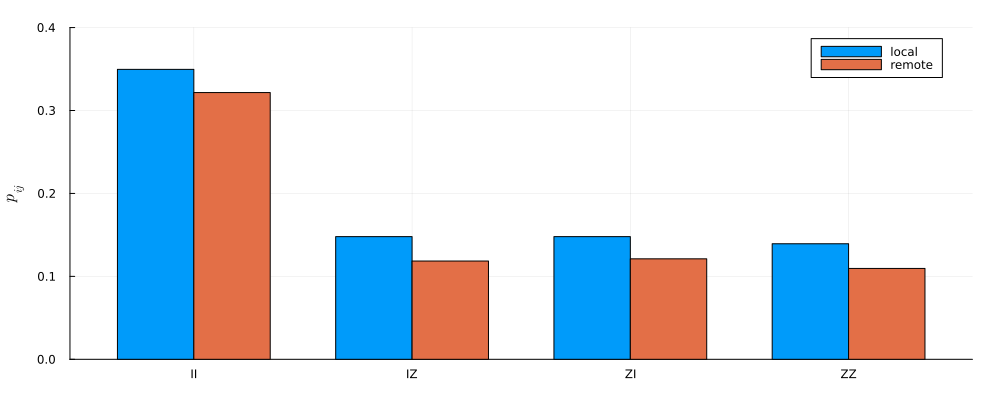

In [40]:
inds = [1,4,13,16]
labels = repeat(["II","IZ","ZI","ZZ"], outer=2)
data = [error_rates_local[inds] error_rates_remote[inds]]
legend = repeat(["local","remote"],inner=4);

p = groupedbar(labels,data,group=legend,bar_position=:dodge, bar_width=0.7)
plot(p,ylims=(0,0.4),ylabel=L"$p_{ij}$"; kwargs...) 

In [41]:
[collect(zip(["II","IZ","ZI","ZZ"],error_rates_local[inds])), collect(zip(["II","IZ","ZI","ZZ"],error_rates_remote[inds]))]

2-element Vector{Vector{Tuple{String, Float64}}}:
 [("II", 0.3496267087892754), ("IZ", 0.14794273066037542), ("ZI", 0.1479427306603754), ("ZZ", 0.13936105497325024)]
 [("II", 0.32165997962585124), ("IZ", 0.11852761189384366), ("ZI", 0.12115843782297132), ("ZZ", 0.10961040754340026)]

## Fig. 15 / 16 - Addressing Requirements

In [42]:
distances = collect(LinRange(1,6,101)) 
detuning_range = 10 .^LinRange(0,3,301)

function calculate_g_range(distances::Vector{<:Real})
    fiber = fiber_parameters(l = 1, n1 = 1.4537, n2 = 1., a = 200e-9, λ = 852.3e-9)
    gridsize, posmax = 400, 10
    x = LinRange(-posmax,posmax,gridsize)
    dx = abs(x[2]-x[1])

    intensity_full = [sum(abs2.(fiber_mode_linear([x,y,0.],fiber; pol_angle = 0.))) for y in x, x in x]  
    g_lin = fiber_coupling(fiber,intensity_full,dx, Lcav = 0.15, dipole_factor = sqrt(5/18))

    intensity_linear = abs2.([fiber_mode_linear([x,0.,0.],fiber; pol_angle = 0.)[1] for x in distances]) # E_x only
    g_range = g_lin*sqrt.(intensity_linear)

    return g_range
end;

In [43]:
g_range = calculate_g_range(distances)
r0 = 1.5 
g0 = g_range[findmin(abs.(distances .- r0))[2]]
    
function Fig15_16(mode::Symbol; threshold::Real = 0.97)
    func = Symbol(String(mode) * "_gate")
    channel = @eval $func
    
    fid = zeros(length(detuning_range),length(g_range))
    ps = zeros(length(detuning_range),length(g_range))

    sys = System(N = 4, κr = 2.5, κm = 0.1, κt = 0.1; mode)
    input = normalize(ones(2^sys.N))
    target = CZ_unitary(input,sys)
    # for purposes of the heatmap plots using approximative fidelity calculation is sufficient and a lot faster
    # otherwise uncomment line below and adjust fidelity calculation inside the loop
    # target = choi(CZ_unitary(nothing,sys))*choi_state(sys.N)
    target_atoms = get_targets(sys)

    for (i,detuning) in enumerate(detuning_range)

        set_detuning(sys,detuning) # target atoms automatically always on resonance

        for (j,coupling) in enumerate(g_range)

            set_coupling(sys,coupling)
            set_coupling.(target_atoms,g0)

            # see comment above regarding approximate fidelity calculation
            fid[i,j] = fidelity(channel(density_matrix(input),sys),target)
            # fid[i,j] = fidelity(channel(nothing,sys,choi=true),target,choi=true) 

            ps[i,j] = success_probability(sys)

        end
    end
                
    sys = System(N = 2, κr = 2.5, κm = 0.1, κt = 0.1, coupling = g0; mode)
    target = choi(CZ_unitary(nothing,sys))*choi_state(sys.N)
    fid_max = fidelity(channel(nothing,sys,choi=true),target,choi=true)
    ps0 = success_probability(sys)
                
    border = [detuning_range[findmin(abs.(fid[:,i] .- threshold))[2]] for i = 1:length(g_range)]
    
    return fid, ps, fid_max, ps0, border
end
                
fidelity_local, ps_local, fid_local_max, ps0_local, border_local  = Fig15_16(:local)
fidelity_remote, ps_remote, fid_remote_max, ps0_remote, border_remote = Fig15_16(:remote)
                    
infidelity_local = @. log10(1 - fidelity_local)
excess_ps_local = ps_local .- ps0_local
infidelity_remote = @. log10(1 - fidelity_remote)
excess_ps_remote = ps_remote .- ps0_remote;
                        
println("Values:")
println("g0: $(g0)\nLocal gate F_max: $(fid_local_max)\nRemote gate F_max: $(fid_remote_max)")

Values:
g0: 10.826794059874505
Local gate F_max: 0.9988324169615934
Remote gate F_max: 0.9937085695187007


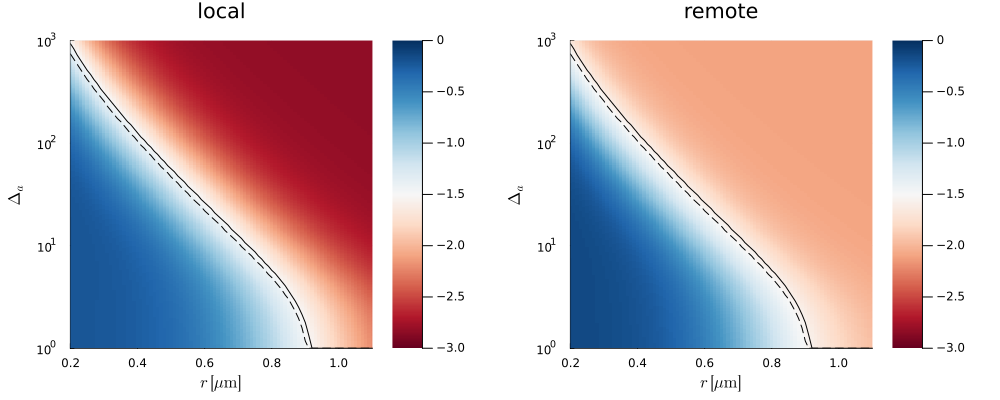

In [44]:
distance = 200e-3*LinRange(1,6,101)
p1 = heatmap(distance,detuning_range,infidelity_local,cmap=:RdBu,title="local")
p1 = plot!(distance,border_local,color=:black,legend=:none)
p1 = plot!(distance,border_remote,color=:black,legend=:none,ls=:dash)
p2 = heatmap(distance,detuning_range,infidelity_remote,cmap=:RdBu,title="remote")
p2 = plot!(distance,border_local,color=:black,legend=:none)
p2 = plot!(distance,border_remote,color=:black,legend=:none,ls=:dash)
plot(p1,p2,layout=(1,2),yscale=:log10,xlims=(0.2,1.1),ylims=(1,1e3),clims=(-3,0),xlabel=L"r\;[\mu\mathrm{m}]",ylabel=L"\Delta_a"; kwargs...)

In [45]:
fname = "data/local_remote_gate_N4_distance_detuning_borders_choi.dat"
labels = ["r" "border_local" "border_remote"]
data = [distance border_local border_remote]
save_data(fname,labels,data)

### Calculating required laser power for targeting beam at λ = 1480 nm

In [46]:
LS = LevelStructure(:cesium)
ω = 2*π*c/1480e-9
α = polarizability(Level("6P3/2"; F=5, mF=0),LS,ω) - polarizability(Level("6S1/2"; F=4, mF=0),LS,ω)

# tabulated values from Eur. Phys. J. D 67, 92 (2013). at λ = 1480 nm result in slightly lower polarizability
# αSS = 598.744372509046
# αSP = 16400.9551617146
# αTP = -16361.6513622407 

# α = convert_alpha(αSP - 2*αTP/3 - αSS,:SI)

detuning_range = 10 .^LinRange(0,3,301)
w0 = 2e-6 # beam waist
detunings = 2*π*1e6*[minimum(detuning_range) maximum(detuning_range)]

# power in mW
P_avg_range = 2*π*ħ*c*ϵ0*w0^2*detunings/α
P_avg_range /= 1e-3 
(P_avg_range,convert_alpha(α,:AU))

println("Values:")
println("Laser power min: $(P_avg_range[1]) mW\nLaser power max: $(P_avg_range[2]) mW\nPolarizability: $(convert_alpha(α,:AU)) a.u.")

Values:
Laser power min: 0.09766569476802914 mW
Laser power max: 97.66569476802916 mW
Polarizability: 27451.196938148125 a.u.


## Fig. 16 - Excess Probability

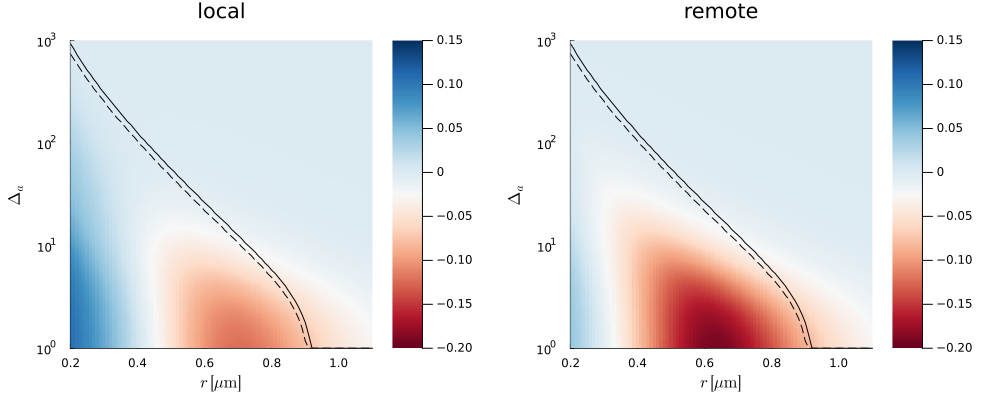

In [47]:
distance = 200e-3*LinRange(1,6,101)
p1 = heatmap(distance,detuning_range,excess_ps_local,cmap=:RdBu,title="local")
p1 = plot!(distance,border_local,color=:black,legend=:none)
p1 = plot!(distance,border_remote,color=:black,legend=:none,ls=:dash)
p2 = heatmap(distance,detuning_range,excess_ps_remote,cmap=:RdBu,title="remote")
p2 = plot!(distance,border_local,color=:black,legend=:none)
p2 = plot!(distance,border_remote,color=:black,legend=:none,ls=:dash)
plot(p1,p2,layout=(1,2),yscale=:log10,xlims=(0.2,1.1),ylims=(1,1e3),clims=(-0.2,0.15),xlabel=L"r\;[\mu\mathrm{m}]",ylabel=L"\Delta_a"; kwargs...)